In [14]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

In [30]:
# Configuration
config = {
    'SWEI_input_dir': project_root / 'data' / 'output_data' /  '1980_2024' / 'comparison'/ 'For_SWEI_calculation.csv',
    'SPI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SPI_2005_unstacked.csv',
    'SnoDRI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SnoDRI_2005_unstacked.csv',
    'normalized': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'Drought_Indices_Comparison_Normalized.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles' / 'BowRiverBasin' / 'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024' / 'comparison',
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
config['plots'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Calculate monthly SWEI for 2005

In [16]:
# load SWEI input data
swe_df = pd.read_csv(config['SWEI_input_dir'], parse_dates=['date'])
print(f"Loaded SWEI input data from: {config['SWEI_input_dir']}")

#drop columns if they exist
cols_to_drop = ['time', 'lon','lat']
swe_df = swe_df.drop(columns=[col for col in cols_to_drop if col in swe_df.columns], errors='ignore')

# add month column
swe_df['month'] = swe_df['date'].dt.month

# select data for season 2005 (Oct 2005 to Sep 2006)
swe_df = swe_df[(swe_df['date'] >= '2005-10-01') & (swe_df['date'] < '2006-10-01')]


display(swe_df.head())

Loaded SWEI input data from: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\For_SWEI_calculation.csv


,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month
6081,2005-10-01,1,11.274902,2000_2500m,2005,3.475098,10
6082,2005-10-02,1,14.750000,2000_2500m,2005,0.125000,10
6083,2005-10-03,1,14.875000,2000_2500m,2005,0.750000,10
6084,2005-10-04,1,15.625000,2000_2500m,2005,0.000000,10
6085,2005-10-05,1,14.875000,2000_2500m,2005,0.000000,10


In [17]:
# perturb daily_SWE_change for both subsets
swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df.head())

,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month,perturb_SWE
6081,2005-10-01,1,11.274902,2000_2500m,2005,3.475098,10,3.475098
6082,2005-10-02,1,14.750000,2000_2500m,2005,0.125000,10,0.125000
6083,2005-10-03,1,14.875000,2000_2500m,2005,0.750000,10,0.750000
6084,2005-10-04,1,15.625000,2000_2500m,2005,0.000000,10,0.000009
6085,2005-10-05,1,14.875000,2000_2500m,2005,0.000000,10,0.000011


In [49]:
# Sum daily_SWE_change by Grid_id and month
sum_daily_SWE = (
    swe_df
    .groupby(['Grid_id', 'month'], as_index=False)['daily_SWE_change']
    .sum()
    .rename(columns={'daily_SWE_change': 'sum_daily_SWE_change'})
)
#keep Elevation column
sum_daily_SWE = sum_daily_SWE.merge(swe_df[['Grid_id', 'Elevation_Category']].drop_duplicates(), on='Grid_id', how='left')

display(sum_daily_SWE.head())


,Grid_id,month,sum_daily_SWE_change,Elevation_Category
0,1,1,41.250000,2000_2500m
1,1,2,28.250000,2000_2500m
2,1,3,13.875000,2000_2500m
3,1,4,22.500980,2000_2500m
4,1,5,33.237305,2000_2500m


In [42]:
# integrate perturb_SWE by Grid_id, season_year, month
def _integrate_perturb(group):
    group = group.sort_values('date')
    if group.shape[0] < 2:
        # single observation -> zero-area (or you could set to NaN)
        return pd.Series({
            'integrated_perturb_SWE': 0.0,
            'n_obs': int(group.shape[0]),
            'start_date': group['date'].iloc[0],
            'end_date': group['date'].iloc[0]
        })
    # x in days since first observation
    x = (group['date'] - group['date'].iloc[0]).dt.total_seconds() / 86400.0
    y = group['perturb_SWE'].values
    area = trapz(y, x)
    return pd.Series({
        'integrated_perturb_SWE': float(area),
        'n_obs': int(group.shape[0]),
        'start_date': group['date'].iloc[0],
        'end_date': group['date'].iloc[-1]
    })

perturb_integrated = swe_df.groupby(['Grid_id', 'season_year', 'month']).apply(_integrate_perturb).reset_index()

#keep elevation category
elevation_mapping = swe_df[['Grid_id', 'Elevation_Category']].drop_duplicates()

perturb_integrated = perturb_integrated.merge(elevation_mapping, on='Grid_id', how='left')

display(perturb_integrated)

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category
0,1,2005,1,41.125036,31,2006-01-01,2006-01-31,2000_2500m
1,1,2005,2,25.062582,28,2006-02-01,2006-02-28,2000_2500m
2,1,2005,3,13.312653,31,2006-03-01,2006-03-31,2000_2500m
3,1,2005,4,21.563164,30,2006-04-01,2006-04-30,2000_2500m
4,1,2005,5,23.425057,31,2006-05-01,2006-05-31,2000_2500m
...,...,...,...,...,...,...,...,...
2051,257,2005,4,0.130602,30,2006-04-01,2006-04-30,500_1000m
2052,257,2005,5,0.000233,31,2006-05-01,2006-05-31,500_1000m
2053,257,2005,10,0.251380,31,2005-10-01,2005-10-31,500_1000m
2054,257,2005,11,3.626036,30,2005-11-01,2005-11-30,500_1000m


In [50]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
sum_daily_SWE['gringorten_probability'] = sum_daily_SWE.groupby('Grid_id')['sum_daily_SWE_change'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(sum_daily_SWE)

,Grid_id,month,sum_daily_SWE_change,Elevation_Category,gringorten_probability
0,1,1,41.250000,2000_2500m,0.931034
1,1,2,28.250000,2000_2500m,0.438424
2,1,3,13.875000,2000_2500m,0.068966
3,1,4,22.500980,2000_2500m,0.192118
4,1,5,33.237305,2000_2500m,0.807882
...,...,...,...,...,...
2051,257,4,0.260742,500_1000m,0.315271
2052,257,5,0.000000,500_1000m,0.068966
2053,257,10,0.251160,500_1000m,0.192118
2054,257,11,3.751221,500_1000m,0.438424


In [51]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
sum_daily_SWE['SSWEI'] = sum_daily_SWE.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(sum_daily_SWE)

,Grid_id,month,sum_daily_SWE_change,Elevation_Category,gringorten_probability,SSWEI
0,1,1,41.250000,2000_2500m,0.931034,1.483540
1,1,2,28.250000,2000_2500m,0.438424,-0.154967
2,1,3,13.875000,2000_2500m,0.068966,-1.483540
3,1,4,22.500980,2000_2500m,0.192118,-0.870117
4,1,5,33.237305,2000_2500m,0.807882,0.870117
...,...,...,...,...,...,...
2051,257,4,0.260742,500_1000m,0.315271,-0.480964
2052,257,5,0.000000,500_1000m,0.068966,-1.483540
2053,257,10,0.251160,500_1000m,0.192118,-0.870117
2054,257,11,3.751221,500_1000m,0.438424,-0.154967


In [52]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = sum_daily_SWE.groupby(['month', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='month', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1,0.394032,-0.190907,0.529059,0.522673
1,2,1.368331,0.640249,-0.117959,1.114816
2,3,0.001269,-0.204524,-0.929490,0.982957
3,4,-0.427147,-0.200831,0.289880,-0.758226
4,5,-1.321940,-0.394029,0.388281,-1.358630
5,10,-0.795086,-0.243384,-0.201346,-0.717766
6,11,0.972354,1.154591,0.829942,0.230779
7,12,-0.191814,-0.561165,-0.788366,-0.016604


In [22]:
# load SPI and SnoDRI data
spi_df = pd.read_csv(config['SPI_dir'])
snodri_df = pd.read_csv(config['SnoDRI_dir'])

display(spi_df.head())
display(snodri_df.head())

,month,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
0,10,-0.052669,-0.013912,0.549937,0.393079
1,11,0.131721,0.276616,-0.712863,-0.074196
2,12,-1.209708,-1.036021,-1.424022,-0.908139
3,1,-0.349224,-0.382049,0.390312,0.233379
4,2,0.466405,0.035853,-0.213536,0.368217


,month,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,10,-0.115257,-0.069547,-0.442011,0.290900
1,11,-0.813266,-0.493289,-1.002818,-0.851282
2,12,-1.319670,-1.064800,-1.548815,-1.061381
3,1,-1.560030,-1.309877,-1.194094,-0.645319
4,2,-1.733270,-1.635242,-1.514538,-1.579057


In [38]:
# Plot SSWEI, SPI, and SnoDRI by elevation categories
merged = average_SSWEI_per_year.merge(spi_df, on='month').merge(snodri_df, on='month')
display(merged.head())

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.383165,-0.058331,0.741496,0.565330,-0.349224,-0.382049,0.390312,0.233379,-1.560030,-1.309877,-1.194094,-0.645319
1,2,1.377912,0.629970,-0.051821,1.025301,0.466405,0.035853,-0.213536,0.368217,-1.733270,-1.635242,-1.514538,-1.579057
2,3,0.079939,-0.055317,-0.921746,1.138078,-0.891061,-1.640496,-0.784207,0.422021,-1.222573,-1.564547,-1.140520,-0.390085
3,4,-0.370709,-0.157756,0.466893,-0.848035,-0.159193,-0.427991,0.554801,0.658789,-0.419585,-0.697759,-0.351740,0.677528
4,5,-1.375807,-0.578864,-0.036872,-1.371586,-0.376534,-0.464000,-0.473230,0.435772,0.514175,0.246189,0.280825,1.513291


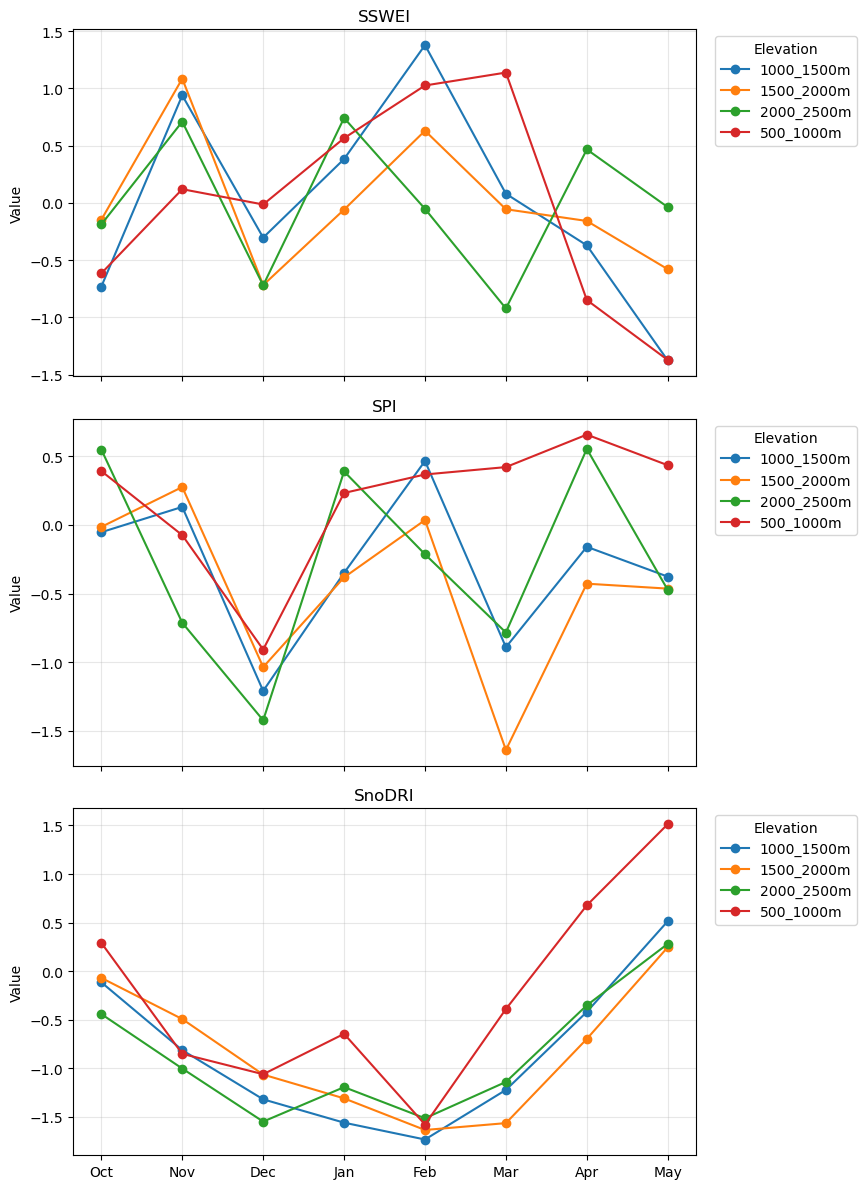

In [41]:
# Plot three separate graphs (SSWEI, SPI, SnoDRI) from `merged`
# Uses existing variables: merged, month_order, elev_colors, out_file2

# prepare month ordering
try:
    merged_plot = merged.set_index('month').loc[month_order].reset_index()
except Exception:
    merged_plot = merged.copy()

# determine elevation category columns (base names without suffixes)
elevations = [c for c in merged_plot.columns if c != 'month' and not c.endswith('_SPI') and not c.endswith('_SnoDRI')]
elevations = sorted(elevations)

# define indices and labels
suffixes = [('', 'SSWEI'), ('_SPI', 'SPI'), ('_SnoDRI', 'SnoDRI')]

# x positions and month labels
x = np.arange(len(merged_plot))
month_labels = pd.to_datetime(merged_plot['month'].astype(str), format='%m').dt.strftime('%b')

# create figure with 3 stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for ax, (suf, title) in zip(axes, suffixes):
    for elev in elevations:
        col = elev + suf
        if col in merged_plot.columns:
            color = elev_colors.get(elev) if 'elev_colors' in globals() else None
            ax.plot(x, merged_plot[col], marker='o', label=elev, color=color)
    ax.set_title(title)
    ax.set_ylabel('Value')
    ax.grid(alpha=0.3)
    ax.legend(title='Elevation', bbox_to_anchor=(1.02, 1), loc='upper left')

# finalize x-axis
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(month_labels)
fig.tight_layout(rect=[0, 0, 0.88, 1])  # leave space for legends
fig.savefig(out_file2, dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Normalize merged using the same per-column min/max found in normalized_df
cols_to_norm = [c for c in merged.columns if c != 'month']
merged_normalized = merged.copy()

for col in cols_to_norm:
    # try to find matching column in normalized_df
    if col in normalized_df.columns:
        ref_col = col
    elif col.endswith('_SnoDRI') and f"{col}_z" in normalized_df.columns:
        ref_col = f"{col}_z"
    else:
        ref_col = None

    if ref_col is not None:
        ref_min = normalized_df[ref_col].min()
        ref_max = normalized_df[ref_col].max()
    else:
        # fallback to merged's own range if no reference scale available
        ref_min = merged[col].min()
        ref_max = merged[col].max()

    if ref_max == ref_min:
        # avoid division by zero
        merged_normalized[col] = 0.0
    else:
        merged_normalized[col] = (merged[col] - ref_min) / (ref_max - ref_min)
        merged_normalized[col] = merged_normalized[col].clip(0.0, 1.0)

display(merged_normalized.head())

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.691583,0.470834,0.870748,0.782665,0.325388,0.308976,0.695156,0.616690,0.000000,0.000000,0.000000,0.177341
1,2,1.000000,0.814985,0.474090,1.000000,0.733203,0.517927,0.393232,0.684109,0.000000,0.000000,0.000000,0.000000
2,3,0.539970,0.472341,0.039127,1.000000,0.054470,0.000000,0.107897,0.711011,0.000000,0.000000,0.000000,0.304957
3,4,0.314646,0.421122,0.733447,0.075983,0.420404,0.286004,0.777401,0.829394,0.290207,0.151121,0.324130,0.838764
4,5,0.000000,0.210568,0.481564,0.000000,0.311733,0.268000,0.263385,0.717886,0.757088,0.623095,0.640413,1.000000


In [35]:
# Normalize merged using fixed min/max of -2 and 2
cols_to_norm = [c for c in merged.columns if c != 'month']
merged_normalized = merged.copy()

ref_min = -2.0
ref_max = 2.0
den = ref_max - ref_min

for col in cols_to_norm:
    if den == 0:
        merged_normalized[col] = 0.0
    else:
        merged_normalized[col] = ((merged[col] - ref_min) / den).clip(0.0, 1.0)

display(merged_normalized.head())


,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.595791,0.485417,0.685374,0.641333,0.412694,0.404488,0.597578,0.558345,0.109992,0.172531,0.201476,0.338670
1,2,0.844478,0.657493,0.487045,0.756325,0.616601,0.508963,0.446616,0.592054,0.066683,0.091190,0.121366,0.105236
2,3,0.519985,0.486171,0.269564,0.784519,0.277235,0.089876,0.303948,0.605505,0.194357,0.108863,0.214870,0.402479
3,4,0.407323,0.460561,0.616723,0.287991,0.460202,0.393002,0.638700,0.664697,0.395104,0.325560,0.412065,0.669382
4,5,0.156048,0.355284,0.490782,0.157104,0.405866,0.384000,0.381692,0.608943,0.628544,0.561547,0.570206,0.878323


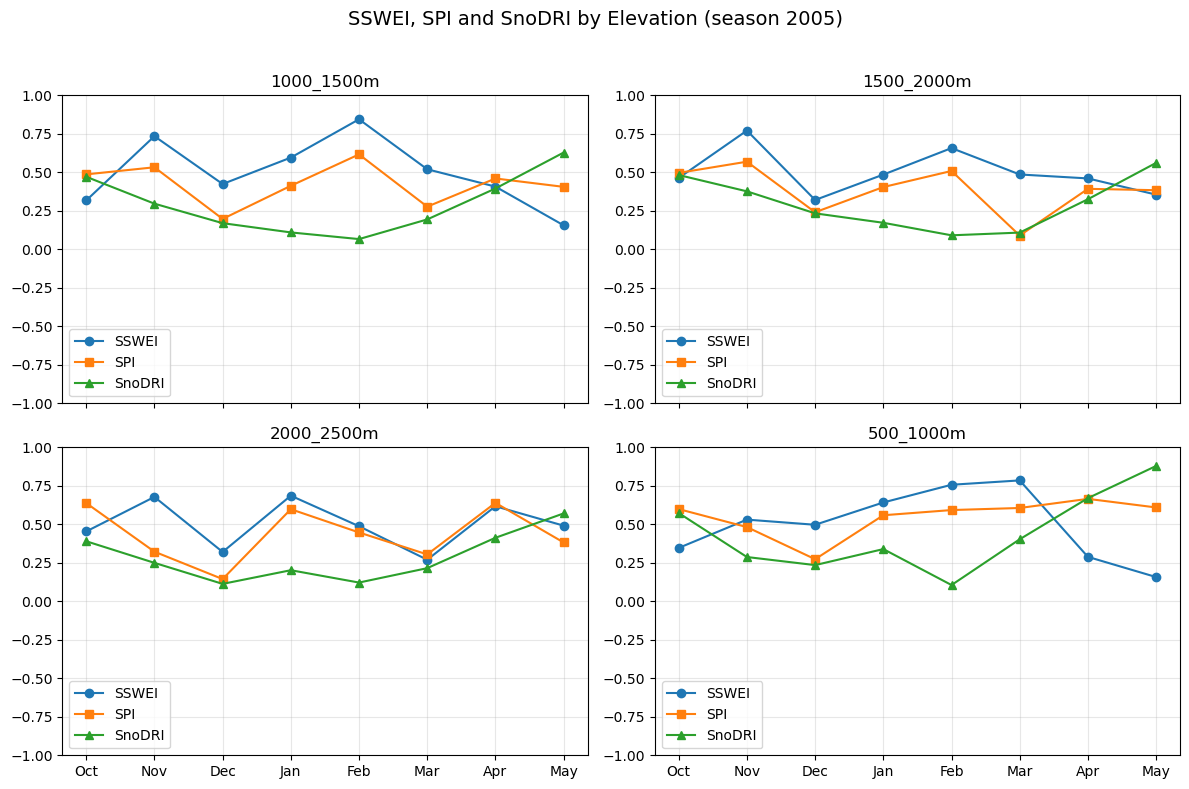

In [36]:
# Plot merged for each elevation (fix x-axis ordering by using ordinal positions)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
try:
    merged_sorted = merged_normalized.set_index('month').loc[month_order].reset_index()
except Exception:
    merged_sorted = merged_normalized.copy()

# derive elevation category column names from merged_sorted (those without _SPI/_SnoDRI suffix)
elevations = [c for c in merged_sorted.columns if c != 'month' and not c.endswith('_SPI') and not c.endswith('_SnoDRI')]
# ensure consistent ordering (you can customize if needed)
elevations = sorted(elevations)

# output file for saving the figure
out_file = config['plots'] / 'comparison_2005_by_elevation.png'

fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes2 = axes2.flatten()
colors = {'SSWEI': 'tab:blue', 'SPI': 'tab:orange', 'SnoDRI': 'tab:green'}

# use integer x positions so months are plotted in the specified order
x = np.arange(len(merged_sorted))
month_labels = pd.to_datetime(merged_sorted['month'].astype(str), format='%m').dt.strftime('%b')

for i, elev in enumerate(elevations):
    ax = axes2[i]
    ax.plot(x, merged_sorted[elev], marker='o', color=colors['SSWEI'], label='SSWEI')
    ax.plot(x, merged_sorted[f'{elev}_SPI'], marker='s', color=colors['SPI'], label='SPI')
    ax.plot(x, merged_sorted[f'{elev}_SnoDRI'], marker='^', color=colors['SnoDRI'], label='SnoDRI')
    ax.set_title(elev)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.grid(alpha=0.3)
    ax.legend()

# same y-axis limits for all subplots
ymin = min(merged_sorted[elev].min() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
ymax = max(merged_sorted[elev].max() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
for ax in axes2:
    ax.set_ylim(-1,1)

# hide any remaining axes
for j in range(len(elevations), len(axes2)):
    axes2[j].set_visible(False)

fig2.suptitle('SSWEI, SPI and SnoDRI by Elevation (season 2005)', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.96])
fig2.savefig(out_file, dpi=300)
plt.show()